This notebook details the data structure and shows how to load the data.

In [1]:
%pylab inline --no-import-all

from pathlib import Path

Populating the interactive namespace from numpy and matplotlib


First, we need to define the path to the data:

In [2]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("data")

This folder is the path root where the data was downloaded and extracted:

In [3]:
ls -L $DATA_PATH

metadata/  observations/  patches/  patches_sample/  pre-extracted/  rasters/


We can now look into these subfolders and the data they contain.

# Observations

The `observations` subfolder contains 4 CSV files:

In [4]:
ls $DATA_PATH/observations

observations_fr_test.csv   observations_us_test.csv
observations_fr_train.csv  observations_us_train.csv


Each of line of those files corresponds to a single observation.

In the files corresponding to the training data, there are 5 columns:
- `observation_id`: unique identifier of the observation
- `latitude`: latitude coordinates of this observation
- `longitude`: longitude coordinates of this observation
- `species_id`: identifier of the species observed at that location
- `subset`: proposed train/val split using the same splitting procedure than for train and test (equal to either "train" or "val")

In the files corresponding to the test data, there are only 3 columns:
- `observation_id`: unique identifier of the observation
- `latitude`: latitude coordinates of this observation
- `longitude`: longitude coordinates of this observation

The goal is then to predict the identifier of the species observed at that location.

Let's load these CSV files using [pandas](https://pandas.pydata.org/):

In [5]:
import pandas as pd

In [6]:
df_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df = pd.concat((df_fr, df_us))

print("Number of observations for training: {}".format(len(df)))

df.head()

Number of observations for training: 1878718


/home/tlorieul/miniconda3/envs/geolifeclef21/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10076047,49.746944,4.686389,38,train
10799362,46.783695,-2.072855,701,train
10392536,48.604866,-2.825003,1460,train


In [7]:
df_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_test = pd.concat((df_fr_test, df_us_test))

print("Number of observations for testing: {}".format(len(df_test)))

df_test.head()

Number of observations for testing: 42405


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


The observations are not uniformly sampled in the two countries as shown the following plots.
The training observations are shown in blue while the test ones are shown in red.

Text(0.5, 1.0, 'Observations distribution (France)')

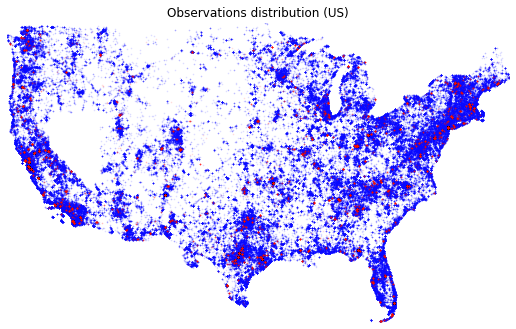

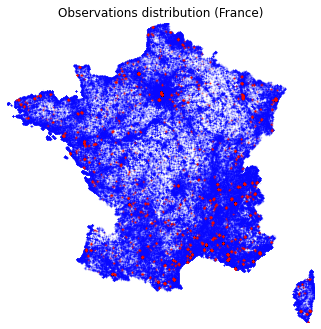

In [8]:
def plot_observations_distribution(ax, df, df_test=None, **kwargs):
    default_kwargs = {
        "zorder": 1,
        "alpha": 0.1,
        "s": 0.5
    }
    default_kwargs.update(kwargs)
    kwargs = default_kwargs
    
    ax.scatter(df.longitude, df.latitude, color="blue", **kwargs)
    
    if df_test is not None:
        ax.scatter(df_test.longitude, df_test.latitude, color="red", **kwargs)

    ax.autoscale(enable=True, axis="both", tight=True)
    ax.axis("off")


fig = plt.figure(figsize=(9, 5.5))
ax = fig.gca()
plot_observations_distribution(ax, df_us, df_us_test)
ax.set_title("Observations distribution (US)")

fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.gca()
plot_observations_distribution(ax, df_fr, df_fr_test)
ax.set_title("Observations distribution (France)")

A close-up view on the region around Montpellier, France, shows the train/test splitting procedure.

Note that there is no geographical overlap between training and test sets.

Text(0.5, 1.0, 'Observations distribution around Montpellier, France')

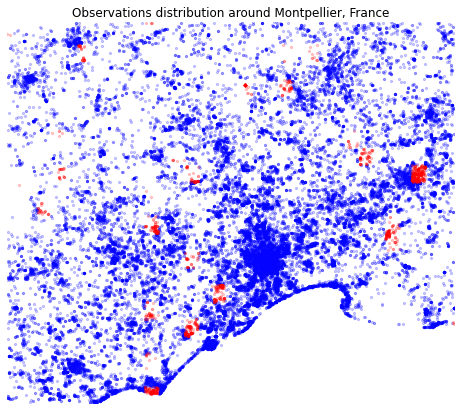

In [9]:
def select_samples_around_point(df, lon_min, lon_max, lat_min, lat_max):
    ind = (
        (lon_min <= df.longitude) & (df.longitude <= lon_max)
        & (lat_min <= df.latitude) & (df.latitude <= lat_max)
    )
    return df[ind]


fig, ax = plt.subplots(figsize=(8, 7))

kwargs = {
    "alpha": 0.2,
    "s": 5,
}
df_zoom = select_samples_around_point(df_fr, 3, 4.5, 43.25, 44.25)
df_zoom_test = select_samples_around_point(df_fr_test, 3, 4.5, 43.25, 44.25)

ax = fig.gca()
plot_observations_distribution(ax, df_zoom, df_zoom_test, **kwargs)
ax.set_title("Observations distribution around Montpellier, France")

# Metadata

In the `metadata` folder, some additional data is provided.
There are 4 files containing:
1. GBIF species names associated with the species id provided in the observations in `species_details.csv`
2. The description of the environmental (bioclimatic and pedological) variables in `environmental_variables.csv`
3. The labels corresponding to the original land cover codes in `landcover_original_labels.csv`
4. The suggested alignment of land cover codes between France and US in `landcover_suggested_alignment.csv`

In [10]:
df_species = pd.read_csv(DATA_PATH / "metadata" / "species_details.csv", sep=";")

print("Total number of species: {}".format(len(df_species)))

df_species.head()

Total number of species: 31435


,species_id,GBIF_species_id,GBIF_species_name
0,0,5356345,Laburnum anagyroides
1,1,2874515,Cucurbita maxima
2,2,2874569,Cucumis sativus
3,3,3033363,Ranunculus acris
4,4,3034830,Heracleum sphondylium


In [11]:
df_env_vars = pd.read_csv(DATA_PATH / "metadata" / "environmental_variables.csv", sep=";")
df_env_vars.head()

,name,description,resolution
0,bio_1,Annual Mean Temperature,30 arcsec
1,bio_2,Mean Diurnal Range (Mean of monthly (max temp ...,30 arcsec
2,bio_3,Isothermality (bio_2/bio_7) (* 100),30 arcsec
3,bio_4,Temperature Seasonality (standard deviation * ...,30 arcsec
4,bio_5,Max Temperature of Warmest Month,30 arcsec


In [12]:
df_landcover_labels = pd.read_csv(DATA_PATH / "metadata" / "landcover_original_labels.csv", sep=";")
df_landcover_labels.head()

,landcover_code,original_landcover_code,landcover_label
0,0,0,Missing Data
1,1,11,Annual Summer Crops
2,2,12,Annual Winter Crops
3,3,31,Broad-leaved Forests
4,4,32,Coniferous Forests


In [13]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
df_suggested_landcover_alignment.head()

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


# Patches

The patches consist of images centered at each observation's location capturing three types of information in the 250m x 250m neighboring square:
1. remote sensing imagery under the form of RGB-IR images
2. land cover data
3. altitude data

They are located in the `patches` subfolder contains 2 subfolders, one for each country:

In [14]:
ls $DATA_PATH/patches

fr/  us/


The first digit of the observation id tells the country it belongs to:
- `1` for France, thus to be found in subfolder `fr`
- `2` for US, thus to be found in subfolder `us`

For instance, `10561949` is an observation made in France whereas `22068175` was observed in the US.

Inside those folders, there are two levels of hierarchy, corresponding to the last four digits of the observation id:

In [15]:
ls $DATA_PATH/patches/fr

00/  07/  14/  21/  28/  35/  42/  49/  56/  63/  70/  77/  84/  91/  98/
01/  08/  15/  22/  29/  36/  43/  50/  57/  64/  71/  78/  85/  92/  99/
02/  09/  16/  23/  30/  37/  44/  51/  58/  65/  72/  79/  86/  93/
03/  10/  17/  24/  31/  38/  45/  52/  59/  66/  73/  80/  87/  94/
04/  11/  18/  25/  32/  39/  46/  53/  60/  67/  74/  81/  88/  95/
05/  12/  19/  26/  33/  40/  47/  54/  61/  68/  75/  82/  89/  96/
06/  13/  20/  27/  34/  41/  48/  55/  62/  69/  76/  83/  90/  97/


and

In [16]:
ls $DATA_PATH/patches/fr/00

00/  07/  14/  21/  28/  35/  42/  49/  56/  63/  70/  77/  84/  91/  98/
01/  08/  15/  22/  29/  36/  43/  50/  57/  64/  71/  78/  85/  92/  99/
02/  09/  16/  23/  30/  37/  44/  51/  58/  65/  72/  79/  86/  93/
03/  10/  17/  24/  31/  38/  45/  52/  59/  66/  73/  80/  87/  94/
04/  11/  18/  25/  32/  39/  46/  53/  60/  67/  74/  81/  88/  95/
05/  12/  19/  26/  33/  40/  47/  54/  61/  68/  75/  82/  89/  96/
06/  13/  20/  27/  34/  41/  48/  55/  62/  69/  76/  83/  90/  97/


To find the files corresponding to an observation:
1. the first subfolder corresponds to the last two digits,
2. the second subfolder corresponds to the two digits right before them.

For instance, the patches corresponding to observation `10561949` can be found in `patches/fr/49/19`, whereas `22068175` can be found in `patches/us/75/81`:

In [17]:
ls $DATA_PATH/patches/fr/49/19/10561949*

data/patches/fr/49/19/10561949_altitude.tif
data/patches/fr/49/19/10561949_landcover.tif
data/patches/fr/49/19/10561949_near_ir.jpg
data/patches/fr/49/19/10561949_rgb.jpg


and

In [18]:
ls $DATA_PATH/patches/us/75/81/22068175*

data/patches/us/75/81/22068175_altitude.tif
data/patches/us/75/81/22068175_landcover.tif
data/patches/us/75/81/22068175_near_ir.jpg
data/patches/us/75/81/22068175_rgb.jpg


There are 4 files for each observation:
- a color JPEG image containing an RGB image (`*_rgb.jpg`)
- a grayscale JPEG image containing a near-infrared image (`*_near_ir.jpg`)
- a TIFF with Deflate compression containing altitude data (`*_altitude.tif`)
- a TIFF with Deflate compression containing land cover data (`*_landcover.tif`)

We provide a loading function which, given an observation id, loads all this data at once using [Pillow](https://pillow.readthedocs.io/en/stable/) for the images and [tiffile](https://github.com/cgohlke/tifffile) for the TIFF files and returns them as a tuple `(rgb, near-ir, altitude, landcover)`:

In [19]:
from GLC.data_loading.common import load_patch

patch = load_patch(10561949, DATA_PATH / "patches")

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


It can also automatically perform the land cover alignment if necessary:

In [20]:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
patch = load_patch(10561949, DATA_PATH / "patches", landcover_mapping)

We also provide an visualization function for the patches:

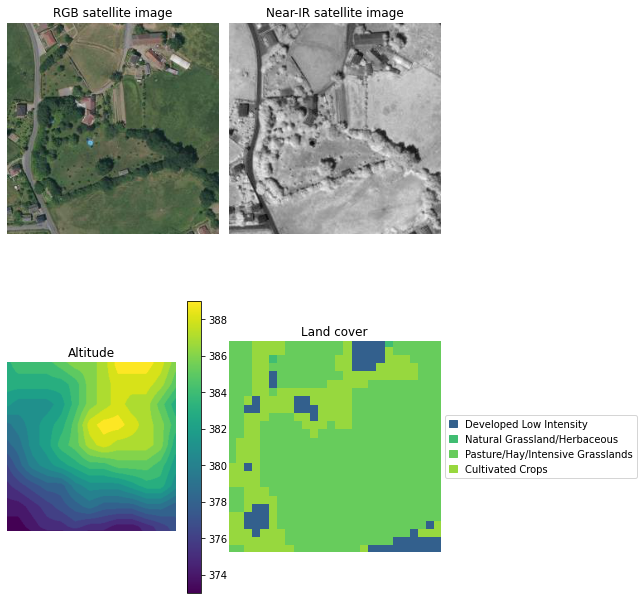

In [21]:
from GLC.plotting import visualize_observation_patch

# Extracts land cover labels
landcover_labels = df_suggested_landcover_alignment[["suggested_landcover_code", "suggested_landcover_label"]].drop_duplicates().sort_values("suggested_landcover_code")["suggested_landcover_label"].values

visualize_observation_patch(patch, landcover_labels)

Similarly, for the observation `22068175`:

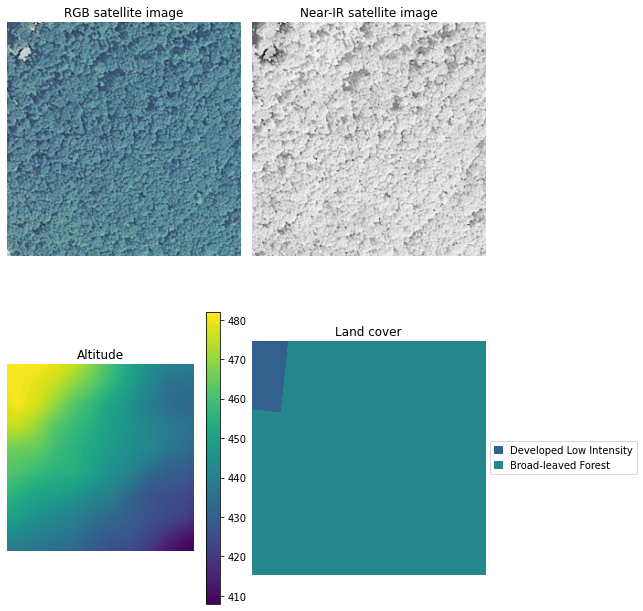

In [22]:
patch = load_patch(22068175, DATA_PATH / "patches", landcover_mapping)

visualize_observation_patch(patch, landcover_labels)

# Environmental rasters

The rasters contain low-resolution environmental data - bioclimatic and pedological data.

There are two ways to use this data:
1. directly use the environmental vectors pre-extracted that can be found in the CSV file `pre-extracted/environmental_vectors.csv`
2. manually extract patches centered at each observation using the rasters located in the `rasters` subfolder

## Pre-extracted environmental vectors

These vectors are ready to be used - see the Random Forest training baseline example below.

They are easy to load as they are provided as a CSV file.

Each line of this file correspond to an observation and each column to one of the environmental variable.

In [23]:
df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")
df_env.head()

/home/tlorieul/miniconda3/envs/geolifeclef21/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,...,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,...,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,...,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,...,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,...,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0


Note that it typically contains NaN values due to absence of data over the seas and oceans for both types of data as well as rivers and others for the pedologic data.

In [24]:
print("Variables which can contain NaN values:")
df_env.isna().any()

Variables which can contain NaN values:


bio_1     True
bio_2     True
bio_3     True
bio_4     True
bio_5     True
bio_6     True
bio_7     True
bio_8     True
bio_9     True
bio_10    True
bio_11    True
bio_12    True
bio_13    True
bio_14    True
bio_15    True
bio_16    True
bio_17    True
bio_18    True
bio_19    True
bdticm    True
bldfie    True
cecsol    True
clyppt    True
orcdrc    True
phihox    True
sltppt    True
sndppt    True
dtype: bool

## Patch extraction from rasters

To more easily extract patches from the rasters, we provide a `PatchExtractor` class which uses [rasterio](https://github.com/mapbox/rasterio).

In [25]:
from GLC.environmental_raster_tools import PatchExtractor

The following code loads the rasters for all the variables and prepares to extract patches of size 256x256.

Here the patches are not of the same resolution as the provided ones as one pixel corresponds to 30arcsec (~1km) for the bioclimatic data and to 250m for the pedologic data.

Note that this uses quite a lot of memory (~10Go) as all the rasters will be loaded in the RAM.

In [ ]:
extractor = PatchExtractor(DATA_PATH / "rasters", size=256)
extractor.add_all()

print("Number of rasters: {}".format(len(extractor)))

A patch can then easily to be extracted given the localization using:

In [ ]:
patch = extractor[43.61, 3.88]

print("Patch shape: {}".format(patch.shape))
print("Data type: {}".format(patch.dtype))

Note that it typically contains NaN values due to absence of data over the seas and oceans for both types of data as well as rivers and others for the pedologic data.

In [ ]:
print("Contains NaN: {}".format(np.isnan(patch).any()))

A helper function to plot the patches is also provided.

The following example displays the patches obtained around the region of Montpellier, France.

In [ ]:
fig = plt.figure(figsize=(14, 16))
extractor.plot((43.61, 3.88), fig=fig)